## Import

In [2]:
import sys

# add the path to the storm_predict module so it's always found
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from torchvision import transforms
from storm_predict.models.image_generate_model import  ImageSequenceDataset, ImageSequenceDatasetDelta, ConvLSTMModel, train,  generate_images, show_images, load_images_from_folder
from storm_predict.loader.speed_loader import StormDataset, get_train_val_loader
from storm_predict.models.wind_speed_model import ConvNet, train_model, show_difference, predict_unknown
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

Using device: mps


Set the device for later training

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


# Task 1---generate future images

Set all necessary parameters

In [4]:
# set the directory of storm images
directory = '../Selected_Storms_curated/tst'
# set window size and number of images we need to predict
window_size = 10
prediction_size = 3
# define the transform
transform = transforms.Compose([
    transforms.Resize((366, 366)),
    transforms.ToTensor(),
])

### Dataset---used to train general models

In [6]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory=directory,
    transform=transform,
    window_size=window_size,
    prediction_size=prediction_size
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

Shape of X in the first batch: torch.Size([1, 7, 1, 366, 366])
Shape of y in the first batch: torch.Size([1, 3, 1, 366, 366])


In [7]:
# Initialize the dataset
dataset_delta = ImageSequenceDatasetDelta(
    directory=directory,
    transform=transform,
    window_size=window_size,
    prediction_size=prediction_size
)

# Create a DataLoader
dataloader_delta = DataLoader(dataset_delta, batch_size=1, shuffle=True)

first_batch = next(iter(dataloader_delta))
X_first_delta, y_first_delta = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first_delta.shape}')
print(f'Shape of y in the first batch: {y_first_delta.shape}')

Shape of X in the first batch: torch.Size([1, 6, 1, 366, 366])
Shape of y in the first batch: torch.Size([1, 3, 1, 366, 366])


### Show the structure of the model

In [8]:
# 366*366 is the size of the images
prediction_shape=(prediction_size, 366, 366, 1)
# build an object of the model
model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
print(model)

ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)


set the loss and optimizer object

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

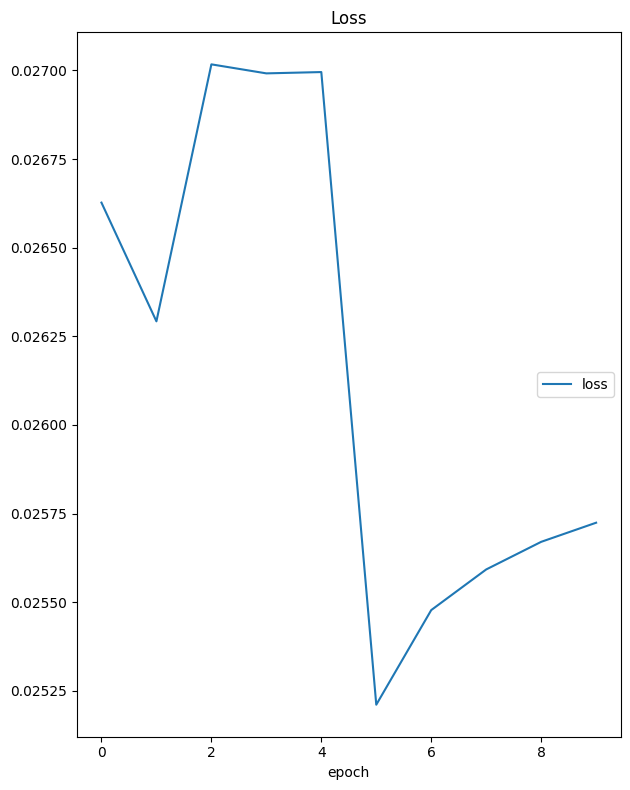

Loss
	loss             	 (min:    0.025, max:    0.027, cur:    0.026)
Epoch 10, Loss: 0.025724047909916184


In [ ]:
# train the model
train(model, dataloader, criterion, optimizer, epochs=10, plot_losses=True, prediction_shape=(prediction_size, 366, 366, 1))

In [ ]:
# save model
torch.save(model.state_dict(), 'model_tst.pt')

### The dataset used on the general model

set the inference as True, so we can plot the last 7 images from dataset

In [ ]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory=directory,
    transform=transform,
    window_size=window_size,
    prediction_size=prediction_size,
    inference=True
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

Shape of X in the first batch: torch.Size([2, 7, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


### Generate the images and Visualization

torch.Size([1, 7, 1, 366, 366])


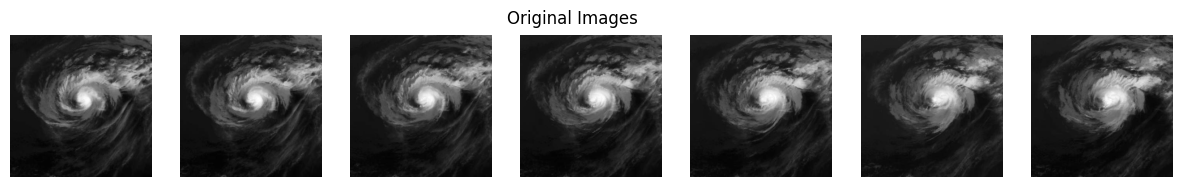

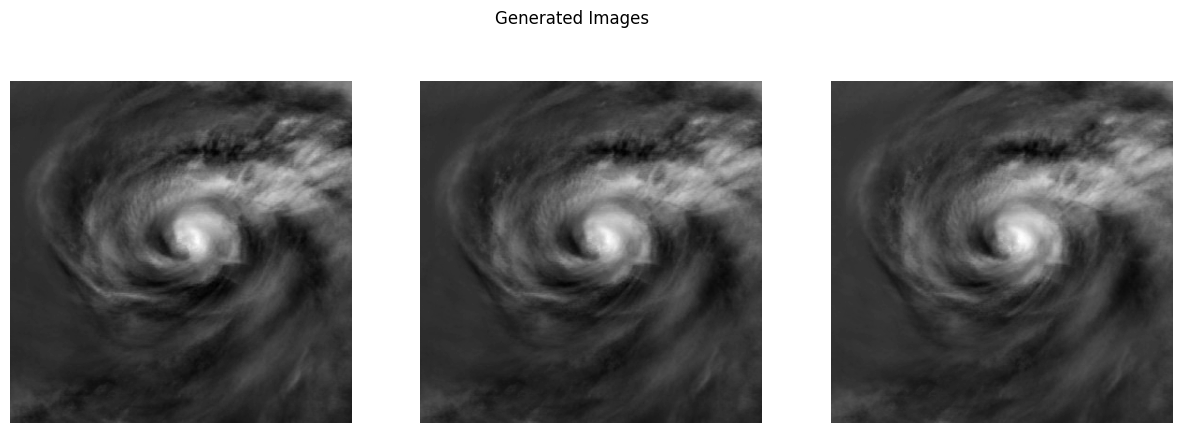

In [ ]:
length_sequence = 7 
for X_batch, y_batch in dataloader:
    pass  # Simply iterate to the end to get the final batch.

# The last batch is now contained in X_batch and y_batch
last_sequence = X_batch[-1].unsqueeze(0)
print(last_sequence.shape)

# Generate new images from the last sequence
new_images = generate_images(model, last_sequence, num_images=prediction_size)

# Show the original images from the last input sequence
original_images = last_sequence.squeeze(0).cpu().numpy()  # Remove batch dimension for plotting
show_images([original_images[i] for i in range(original_images.shape[0])], title='Original Images', figsize=(15, 2))

# Display the generated images
generated_images = new_images.squeeze(0)  # Remove batch dimension for plotting
show_images([generated_images[i] for i in range(generated_images.shape[0])], title='Generated Images', figsize=(15, 5))

storm_name = 'tst' 

for i, img in enumerate(generated_images):
            plt.imsave(os.path.join('../Selected_Storms_curated/tst', f'{storm_name}_{i+252}.jpg'), img.squeeze(), cmap='gray')


# Task2---Predict the wind speed

In [ ]:
data_path = '../Selected_Storms_curated/tst/'

transformer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = StormDataset(root_dir=data_path, start_idx=0, end_idx=-20, transform=transformer)
train_loader, val_loader = get_train_val_loader(dataset, train_size=0.8)

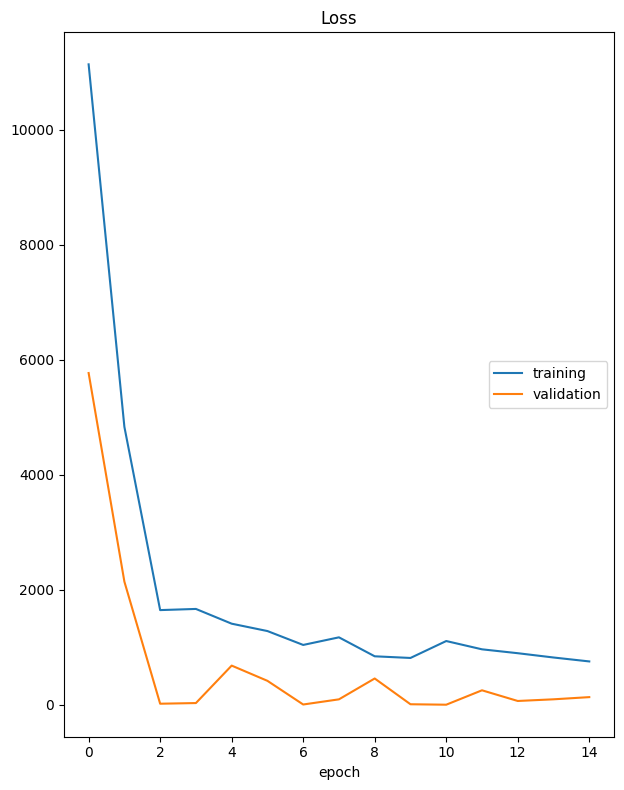

Loss
	training         	 (min:  753.797, max: 11137.424, cur:  753.797)
	validation       	 (min:    1.257, max: 5769.217, cur:  133.045)
Validation Loss: 133.04522323608398


In [ ]:
# Instantiate the model
model = ConvNet().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train
model = train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=15, save_path='best_model.pth')

rmse: 0.6859115176811763


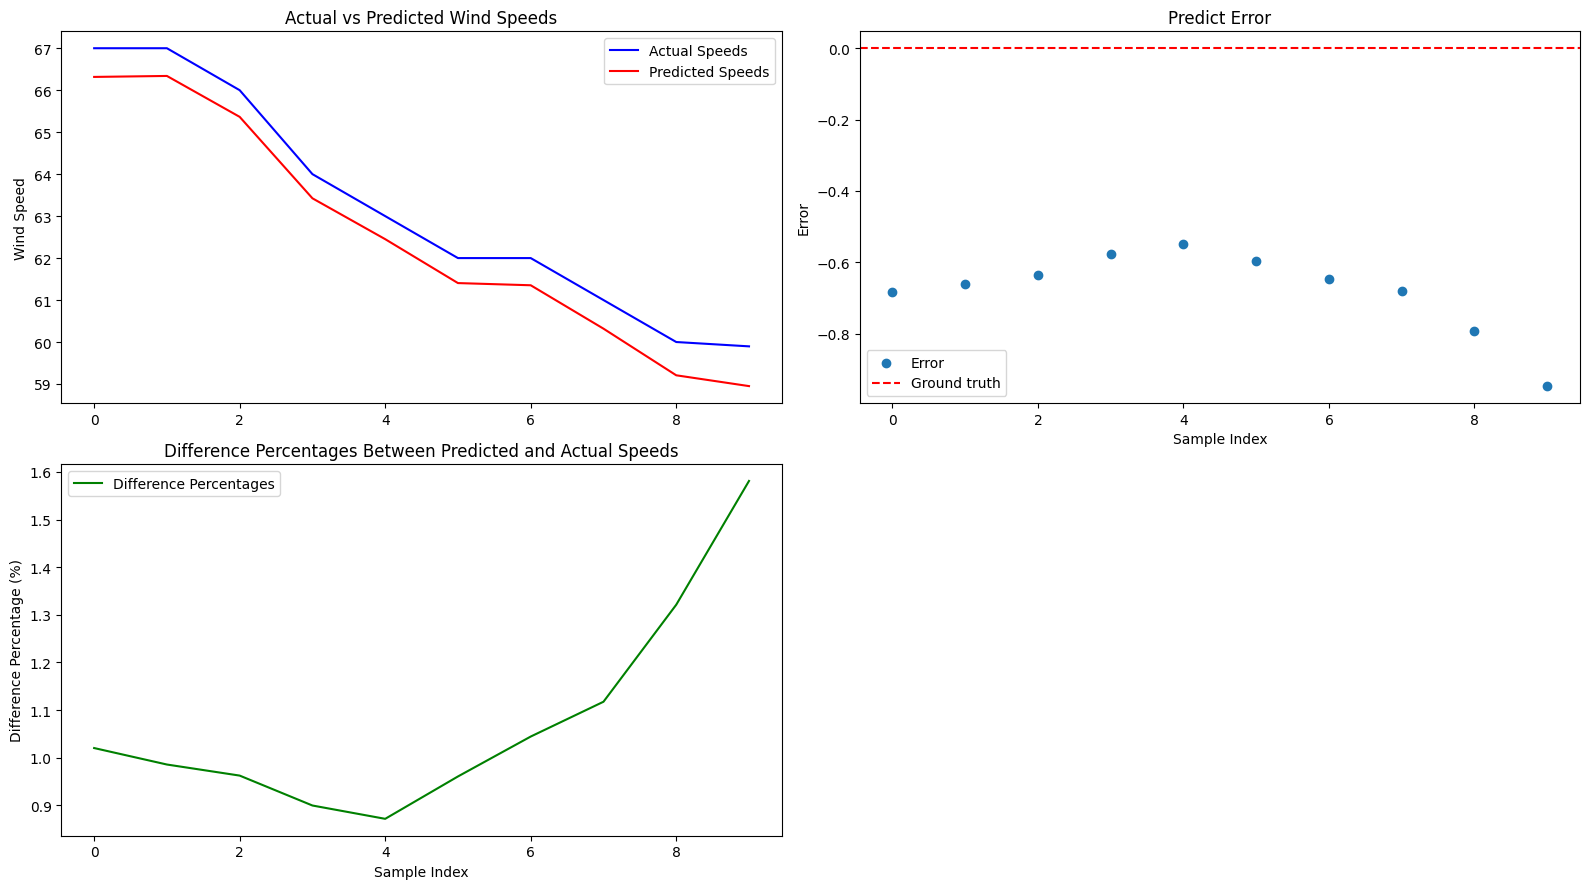

In [ ]:
# pretrained_model = ConvNet().to(device)
# pretrained_model.load_state_dict(torch.load('best_model_tst_v5.0.pth'))
unseen_path = '../Selected_Storms_curated/tst/'
predict_loader = DataLoader(StormDataset(root_dir=unseen_path, start_idx=-25, end_idx=-13, transform=transformer), batch_size=32, shuffle=False)
show_difference(unseen_path, model, predict_loader, device, start=-10)

In [ ]:
result = predict_unknown(unseen_path, model, device, predict_num=13, transformer=transformer)
print(result)

[58.829345703125, 57.74677276611328, 57.43342590332031, 56.264808654785156, 55.900245666503906, 54.761165618896484, 54.43729782104492, 53.34950256347656, 53.07384490966797, 52.10628890991211, 52.08140182495117, 51.371124267578125, 50.76106262207031]
